In [ ]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

  if event.key is 'enter':



In [ ]:
seed_constant=27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

# Check if the directory exists
dataset_path = '/content/drive//My Drive/DeepfakeDataset'  # Update the path if needed
print(os.listdir(dataset_path))


['Deepfake', 'Origial']


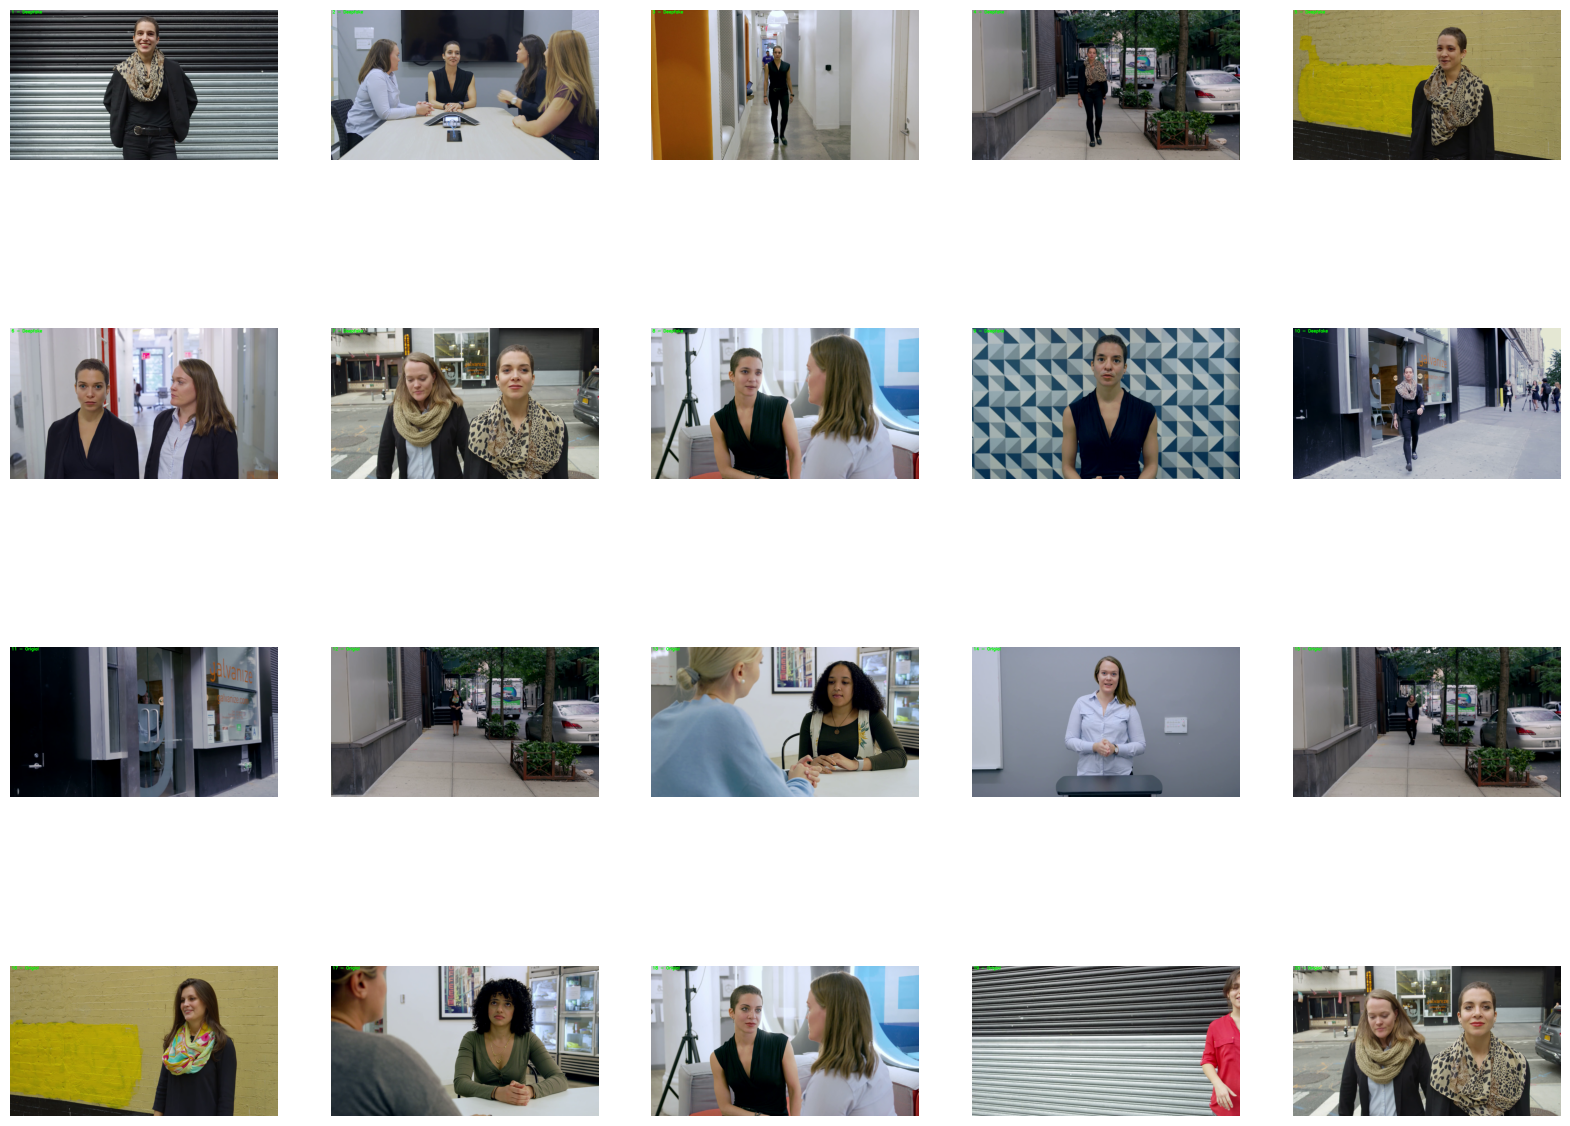

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))

base_path = '//content//drive//My Drive//DeepfakeDataset'
subfolders = ['Deepfake', 'Origial']
videos_per_folder = 10  # 10 videos from each folder to make 20 in total

video_paths = []

# Collect 10 random videos from each subfolder
for subfolder in subfolders:
    folder_path = os.path.join(base_path, subfolder)
    video_files = os.listdir(folder_path)

    if not video_files:
        print(f"No videos found in {subfolder}. Skipping...")
        continue

    # Ensure we do not sample more videos than available
    num_samples = min(videos_per_folder, len(video_files))
    selected_videos = random.sample(video_files, num_samples)

    for video in selected_videos:
        video_paths.append((subfolder, video))

# Visualize the selected videos
for counter, (subfolder, video_name) in enumerate(video_paths, 1):
    video_path = os.path.join(base_path, subfolder, video_name)
    video_reader = cv2.VideoCapture(video_path)

    ret, bgr_frame = video_reader.read()
    video_reader.release()

    if not ret or bgr_frame is None:
        print(f"Could not read video: {video_name}. Skipping...")
        continue

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, f'{counter} - {subfolder}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                1.0, (0, 255, 0), 4)

    plt.subplot(5, 5, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

plt.show()


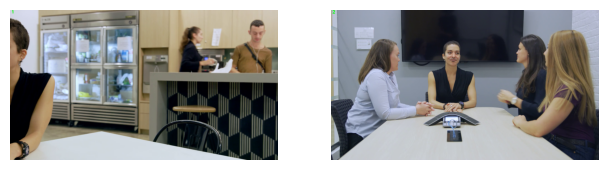

In [ ]:
plt.figure(figsize=(20,20))
all_classes_name=os.listdir(f'drive/My Drive/DeepfakeDataset')
random_range=random.sample(range(len(all_classes_name)),2)
for counter,random_index in enumerate(random_range,1):
    selected_class_name=all_classes_name[random_index]
    video_files_names_list=os.listdir(f'drive/My Drive/DeepfakeDataset/{selected_class_name}')
    selected_video_file_name=random.choice(video_files_names_list)
    video_reader=cv2.VideoCapture(f'drive/My Drive/DeepfakeDataset/{selected_class_name}/{selected_video_file_name}')
    _,bgr_frame=video_reader.read()
    video_reader.release()
    rgb_frame=cv2.cvtColor(bgr_frame,cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame,f'{counter}',(10,30),cv2.FONT_HERSHEY_SIMPLEX,1.0,(0,255,0),4)
    plt.subplot(5,5,counter)
    plt.imshow(rgb_frame)
    plt.axis('off')


In [ ]:
all_classes_name=os.listdir(f'drive/My Drive/DeepfakeDataset')
random_range=random.sample(range(len(all_classes_name)),2)


In [ ]:
random_range

[1, 0]

In [ ]:
IMAGE_HEIGHT,IMAGE_WIDTH=64,64
SEQUENCE_LENGTH=20
DATASET_DIR='drive/My Drive/DeepfakeDataset'
CLASSES_LIST=['Deepfake','Origial']

In [ ]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list


In [ ]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
    features = np.asarray(features)
    labels = np.array(labels)
    return features, labels, video_files_paths

In [ ]:
features,labels,video_files_paths=create_dataset()

Extracting Data of Class: Deepfake
Extracting Data of Class: Origial


In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
features_train,features_test,labels_train,labels_test=train_test_split(features,one_hot_encoded_labels,test_size=0.2,shuffle=True,random_state=seed_constant)

In [ ]:


def create_convLstm_model():
    model = Sequential()

    # First ConvLSTM2D Layer
    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='tanh',
                         data_format='channels_last', recurrent_dropout=0.2,
                         return_sequences=True, input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    # Second ConvLSTM2D Layer
    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh',
                         data_format='channels_last', recurrent_dropout=0.2,
                         return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    # Third ConvLSTM2D Layer
    model.add(ConvLSTM2D(filters=14, kernel_size=(3, 3), activation='tanh',
                         data_format='channels_last', recurrent_dropout=0.2,
                         return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    # Fourth ConvLSTM2D Layer (Fixed Typo)
    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh',
                         data_format='channels_last', recurrent_dropout=0.2,
                         return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

    # Fully Connected Layer
    model.add(Flatten())
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()
    return model


In [ ]:
convlstm_model=create_convLstm_model()
print("Model Create Sucessfully")

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, 20, 62, 62, 4)       │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 20, 29, 29, 8)       │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)           │ (None, 20, 13, 13, 14)      │          11,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)           │ (None, 20, 5, 5, 16)        │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 20, 3, 3, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2880)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │           5,762 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,762 (151.41 KB)

 Trainable params: 38,762 (151.41 KB)

 Non-trainable params: 0 (0.00 B)

Model Create Sucessfully


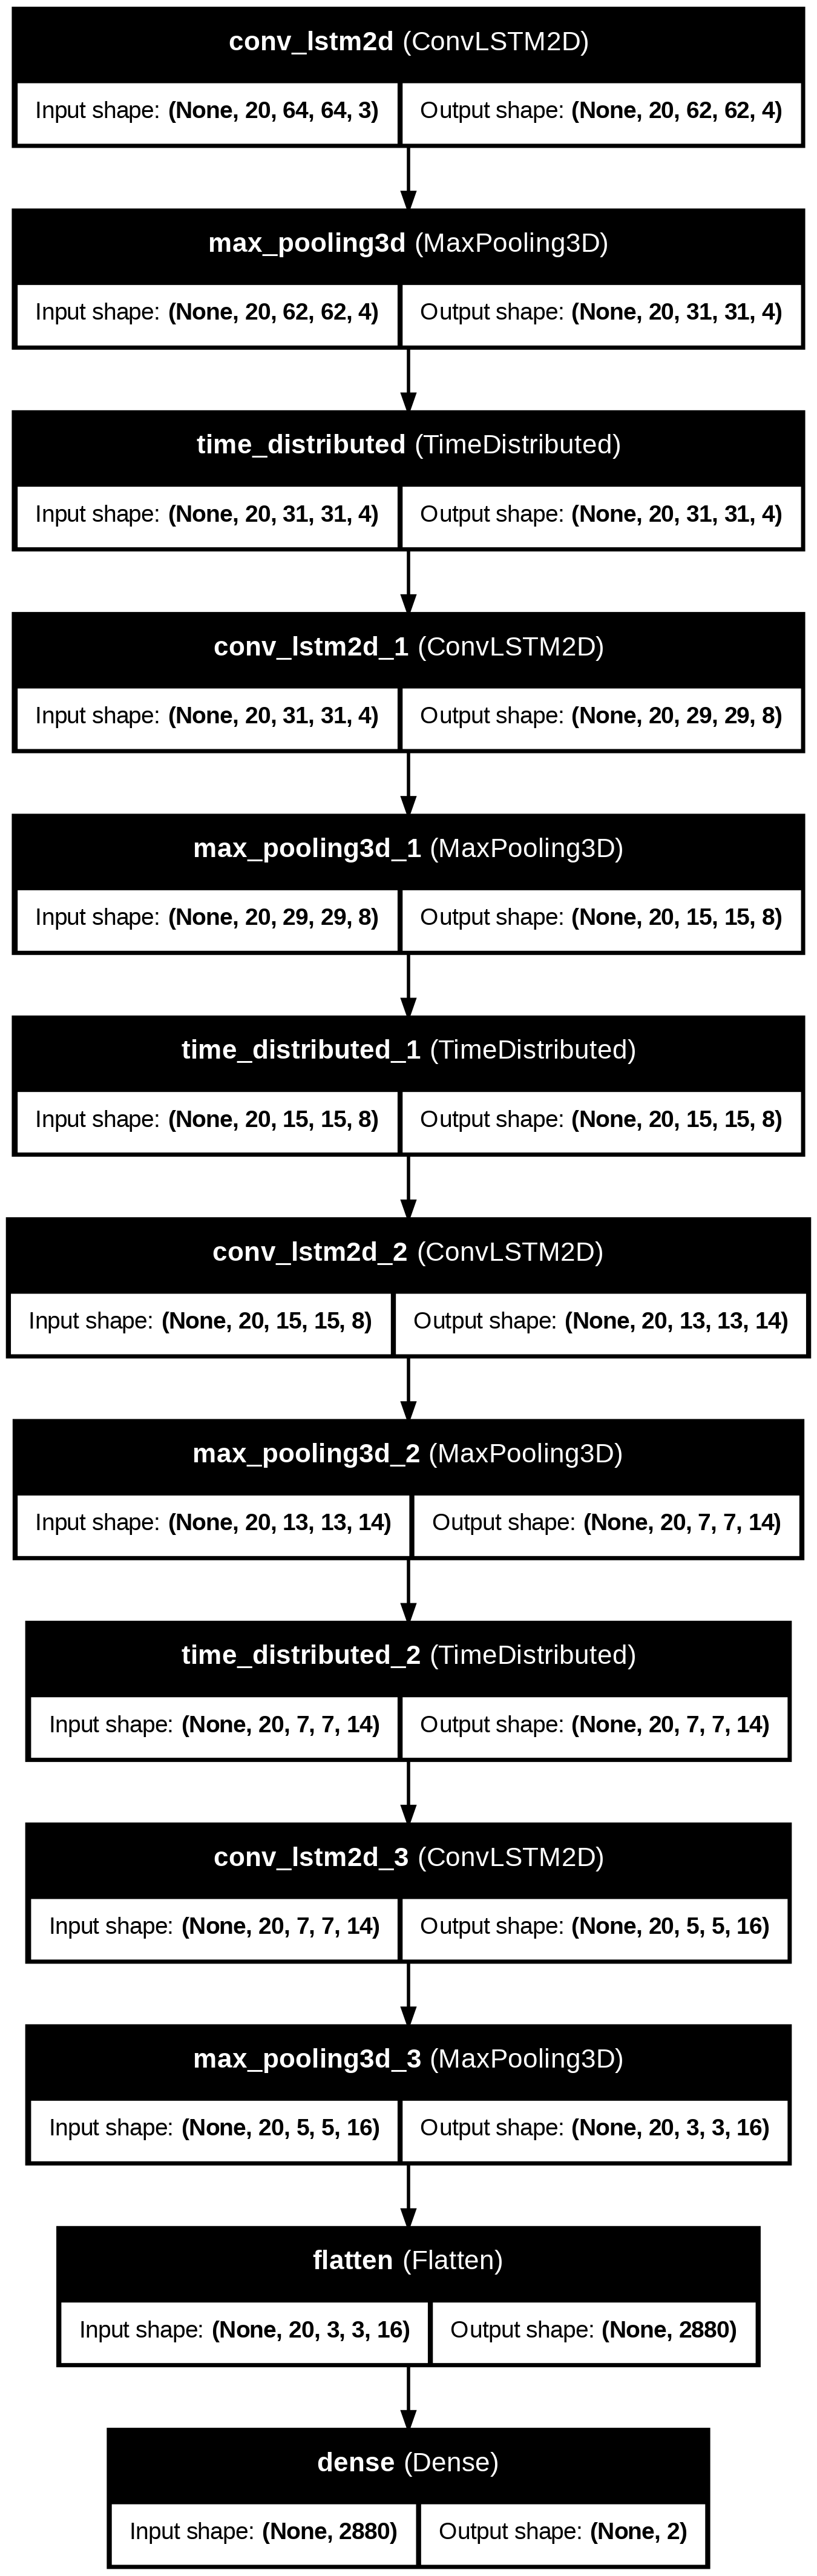

In [ ]:
plot_model(convlstm_model,to_file='convlstm_model_structure_plot.png',show_shapes=True,show_layer_names=True)

In [ ]:
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=10,verbose=1,mode='min',restore_best_weights=True)
convlstm_model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
convlstm_model_training_history=convlstm_model.fit(x=features_train,y=labels_train,epochs=50,batch_size=4,shuffle=True,validation_split=0.2,callbacks=[early_stopping_callback])


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.4998 - loss: 0.6966 - val_accuracy: 0.6296 - val_loss: 0.6564
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.4862 - loss: 0.7107 - val_accuracy: 0.7037 - val_loss: 0.6393
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6782 - loss: 0.6504 - val_accuracy: 0.7037 - val_loss: 0.6209
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6449 - loss: 0.6000 - val_accuracy: 0.6667 - val_loss: 0.5814
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7925 - loss: 0.5276 - val_accuracy: 0.7778 - val_loss: 0.5777
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 991ms/step - accuracy: 0.7866 - loss: 0.4813 - val_accuracy: 0.7778 - val_loss: 0.5482
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 970ms/step - accuracy: 0.7998 - loss: 0.4133 - val_accuracy: 0.5926 - val_loss: 0.6504
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 967ms/step - accuracy: 0.8565 - loss: 0.4311 - val_accuracy: 0.6667 - 

In [ ]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.6697 - loss: 0.7350


In [ ]:
#save model
model_evaluation_loss,model_evaluation_accuracy=model_evaluation_history

date_time_format='%Y_%m_%d__%H_%M_%S'
current_date_time_dt=dt.datetime.now()
current_date_time_string=dt.datetime.strftime(current_date_time_dt,date_time_format)
model_file_name=f'convlstm_model_Date_Time{current_date_time_string}__Loss{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'
convlstm_model.save(model_file_name)



In [ ]:
def plot_metric(model_training_history,metric_name_1,metric_name_2,plot_name):
    metric_value_1=model_training_history.history[metric_name_1]
    metric_value_2=model_training_history.history[metric_name_2]
    epochs=range(len(metric_value_1))
    plt.plot(epochs,metric_value_1,'blue',label=f'{metric_name_1}')
    plt.plot(epochs,metric_value_2,'red',label=f'{metric_name_2}')
    plt.title(str(plot_name))
    plt.legend()
    plt.figure()
    plt.show()

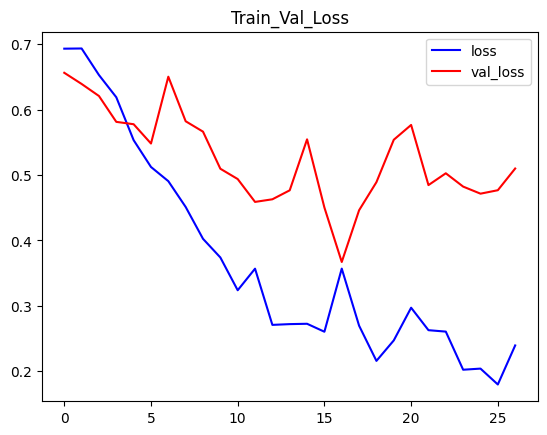

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_metric(convlstm_model_training_history,'loss','val_loss','Train_Val_Loss')

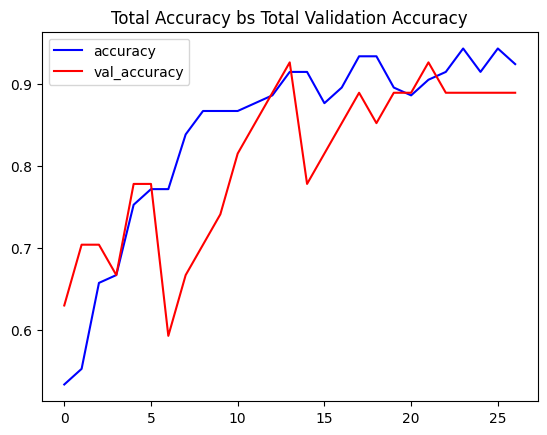

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_metric(convlstm_model_training_history,'accuracy','val_accuracy','Total Accuracy bs Total Validation Accuracy')

In [ ]:
test_videos_directory='test_videos'
os.makedirs(test_videos_directory,exist_ok=True)
video_title='video1'
input_video_file_path='/content/video1'

In [ ]:
import cv2
import numpy as np
from collections import deque

def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH, model, CLASSES_LIST):
    # Initialize video reader and get properties
    video_reader = cv2.VideoCapture(video_file_path)
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize video writer
    video_writer = cv2.VideoWriter(
        output_file_path,
        cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
        fps,
        (original_video_width, original_video_height)
    )

    # Initialize a queue to hold frames for prediction
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    predicted_class_name=''
    while video_reader.isOpened():
        ok, frame = video_reader.read()
        if not ok:
            break

        # Preprocess the frame
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0
        frames_queue.append(normalized_frame)

        # Make predictions only when the queue is full
        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_label_probabilities = convlstm_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_label_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label] # Changed from predicted_class_index to predicted_label

            # Display prediction on the frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                        1, (0, 255, 0), 2)

        # Write the frame to the output video
        video_writer.write(frame)

    # Release resources
    video_reader.release()
    video_writer.release()

    print(f"Output video saved at: {output_file_path}")

In [ ]:
output_video_file_path=f'{test_videos_directory}/{video_title}-output.mp4'
fps = 30  # Define frames per second
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH, convlstm_model, CLASSES_LIST)
VideoFileClip(output_video_file_path,audio=False ,target_resolution=(300,None)).ipython_display()

Output video saved at: test_videos/video1-output.mp4


OSError: MoviePy error: the file test_videos/video1-output.mp4 could not be found!
Please check that you entered the correct path.

In [ ]:
import os
from moviepy.editor import VideoFileClip

# Create the directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok=True)

# Define input and output video paths
video_title = 'video1'
input_video_file_path = '/content/video1.mp4'  # Ensure the correct file extension is included
output_video_file_path = f'{test_videos_directory}/{video_title}-output.mp4'

# Define frames per second (if needed by the predict function)
fps = 30

# Call the prediction function
# Ensure SEQUENCE_LENGTH, convlstm_model, and CLASSES_LIST are properly defined before this call
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH, convlstm_model, CLASSES_LIST)

# Check if the output file was created successfully
if not os.path.exists(output_video_file_path):
    print(f"Error: Output video file not found at {output_video_file_path}")
else:
    # Display the video using MoviePy
    VideoFileClip(output_video_file_path, audio=False, target_resolution=(300, None)).ipython_display()
